In [3]:
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy.ndimage.filters import convolve1d
import itertools
plt.style.use('seaborn-whitegrid')

mpl.rcParams['grid.linestyle'] = ':'   

mpl.rcParams['figure.figsize'] = [20.0, 20.0]
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 400

mpl.rcParams['font.size'] = 14
mpl.rcParams['font.style'] = 'oblique'
mpl.rcParams['font.weight']= 'heavy'

mpl.rcParams['legend.fontsize'] = 'medium'

mpl.rcParams['figure.titlesize'] = 'large'
mpl.rcParams['figure.titleweight'] = 'heavy'

mpl.rcParams['axes.labelsize'] = 'large'
mpl.rcParams['axes.labelweight'] = 'heavy'
mpl.rcParams['axes.titlesize'] = 'large'
mpl.rcParams['axes.titleweight'] = 'heavy'

# print(mpl.rcParams.keys())

   

In [4]:

############################################################
#                  Simulation parameter                    #
############################################################

# Define initial condition (not necessary?)
#x0 = 0

# Time step
dt = 0.001 # -> 10us

# Solve differential equation from time 0 to time T
T = 4.0 # -> 15ms 

# Descretize time into equal steps
t = np . linspace (0 , T , int ( T / dt )+1)




In [5]:
############################################################
#                Network Inputs/Outputs                    #
############################################################

# define the inputs
# assuming we have 16 frquency bands
freq_bands = 5
s_gbc_all= np.zeros((len(t),freq_bands))
s_sbc_all = np.zeros((len(t),freq_bands))






#define the kernels (assuming that they fold over 16 freq_bands)
# x =  np.linspace(0,freq_bands,freq_bands)
# cf = 8



In [6]:
############################################################
#                       Functions                          #
############################################################

#define a gauss function
def gauss(x,mean,sigma):
    if sigma == 0.0:
        return np.zeros(x.shape)
    else: 
        return np.exp(-(x-mean)**2 /( 2 * sigma**2 ))


# Defines the output transfer function of r_bpc
def g_r_out(r_bpc,a =20,b=0.25):
    # build a threshold. make sure we do not change the original array (called by reference)
    if isinstance(r_bpc, (list,np.ndarray)):
        tmp = 1.0*r_bpc
        tmp[tmp < 0.00] = 0.0
    else:
        if r_bpc < 0.00:
            tmp = 0.0
        else:
            tmp = r_bpc
    
    return 1 / (1 + np.exp(-(tmp-b)*a) )

# Defines the output transfer function of q_pc
def g_q_out(q_pc):
    ## Defines a threshold ?
    q_pc[q_pc < 0.000] = 0.0
    return np.maximum(q_pc,0)

# Defines the ODE for the r_bpc neuron
def ode_r_bpc(r_bpc,s_sbc,ee_kernel,q_pc,ei_kernel,bias,gaba_exc=0,gaba_inh=0):
    # get the globally defined parameters
    global tau_r ,alpha_r, beta_r, gamma_r, kappa_r

    # do a subtractive inhibition, this is done by subtracting the g_r_out values from the kernel weights
    # calculate excitatory input, which comes from the SBC cells folded by the E-E kernel

    ee_kernel  = ee_kernel*(1-gaba_exc)
    excitatory_in = np.sum(np.multiply(s_sbc,ee_kernel)) # * 1/( gaba_exc+1.0) 
    # calculate inhibitor input, which comes from the q_pc folded by the I-E kernel
    ei_kernel  = ei_kernel*(1-gaba_inh)
    inhibitory_in = np.sum( np.multiply(g_q_out(q_pc),ei_kernel)) #* 1/(gaba_inh+1.0)       
    # calculate the change of r_bpc
    d_r_bpc = -alpha_r * r_bpc + (beta_r-r_bpc) * excitatory_in - ((gamma_r) + kappa_r * r_bpc) * inhibitory_in + bias*alpha_r
    
#     excitatory_in = np.sum(np.multiply(s_sbc,ee_kernel)) 1
#     # calculate inhibitor input, which comes from the q_pc folded by the I-E kernel
#     inhibitory_in = np.sum( np.multiply(g_q_out(q_pc),ei_kernel))     
#     # calculate the change of r_bpc
#     d_r_bpc = -alpha_r * r_bpc + (beta_r-r_bpc) * excitatory_in - (gamma_r + kappa_r * r_bpc) * inhibitory_in + bias*alpha_r
        
    return d_r_bpc / tau_r


# Defines the ODE for the q_pc neuron
def ode_q_pc(q_pc, s_gbc,ie_kernel,q_pc_all,ii_kernel):
    # get the globally defined parameters
    global tau_q,alpha_q,beta_q,gamma_q,kappa_q

    # calculate excitatory input, which comes from the GBC cells folded by the I-E kernel
    excitatory_in = np.sum(np.multiply(s_gbc,ie_kernel))
    # calculate inhibitor input, which comes from the q_pc folded by the I-I kernel (self-inhibition)
    inhibitory_in = np.sum( np.multiply(g_q_out(q_pc_all),ii_kernel))
    
    d_q_pc = -alpha_q * q_pc + beta_q * excitatory_in - (gamma_q + kappa_q * q_pc) * inhibitory_in 
    
    return  d_q_pc  / tau_r


# Defines the ODE for the p_gaba neuron which defines the strength of the modulation (inhibition) of the inputs of the r neuron
def ode_p_pc(p_gaba, r_gbc):
    # get the globally defined parameters
    global tau_p,alpha_p,beta_p

    d_p_pc =   -alpha_p*p_gaba +(beta_p - p_gaba)*g_r_out(r_gbc)  
    return  d_p_pc  / tau_p

In [7]:



############################################################
#                 BPC neuron parameter                     #
#  parameters for r_bpc neuron of LSO, all marked by a _r  #
############################################################
# tau defines how fast the membrane potential builds up
tau_r = 1/40
# alpha defines the decay rate of the membrane potential but also the value to which it saturates (implicitly)
alpha_r = 1.0
# beta defines the upper limit of the membrane potential
beta_r = 1.0
# gamma defines the subtractive influence of the inhibitory input
gamma_r = 2.0
# kappa defines the divisive influence of the inhibitory input
kappa_r = 2.0

############################################################
#                 PC neuron parameter                      #
#  parameters for q_pc neuron of MNTB, all marked by a _q  #
############################################################
tau_q = 1/40
alpha_q = 2.0 
beta_q = 1.0
gamma_q = 0.0
kappa_q = 0.0

############################################################
#                 GABA neuron parameter                    #
#  parameters for p_gaba inhibitory neuron of LSO, all marked by a _p #
############################################################
tau_p = 25
alpha_p = 10.0
beta_p = 10.0


## Stimuli  Influence on LSP Response

In [16]:

gbc_input_intensities = np.array([0.8,0.9,1.0,0.6])
sbc_input_intensities = np.array([1.0,1.0,1.0,0.6])

gbc_input_intensities = np.array([0.8])
sbc_input_intensities = np.array([1.0])

# store values for different parameters
q_all = np.zeros((len(gbc_input_intensities),len(t),freq_bands))
r_all = np.zeros((len(gbc_input_intensities),len(t),freq_bands))
p_all = np.zeros((len(gbc_input_intensities),len(t),freq_bands))

gaba_inh_values = np.zeros((len(t),freq_bands))
gaba_exc_values = np.zeros((len(t),freq_bands))

# define the spontaneous firing rate of neuron
spf_r = 0.0
r_all[:,0,:] = spf_r
############################################################
#                      Simulation                          #
############################################################
# for gamma_r in [0.0,1.0,5.0]:
#     for kappa_r in [0.0,1.0,5.0]:
for k in range(len(sbc_input_intensities)):
    
    ############################################################
    #                       Inputs                             #
    ############################################################
    s_gbc_all= np.zeros((len(t),freq_bands))
    s_sbc_all = np.zeros((len(t),freq_bands))

    # Define input signal in a plausible way (gaussian input signal over frequency bands?)
    # Define input signal in a plausible way (gaussian input signal over frequency bands?)
    sigma = 2.0

    # MNTB inhibitory input (contra-lateral)
    gbc_input_onset = 200
    gbc_input_duration = 500
    gbc_center_frequencyBand =3
    gbc_input_strength = gbc_input_intensities[k]
   
    # build ramps
    time_window = 200
    gap_window = 30
    for i in range(time_window,len(t)-time_window-2000,time_window+gap_window):
        s_gbc_all[i:i+time_window,gbc_center_frequencyBand] = 1 * gbc_input_strength
        
    for i in range(len(t)-time_window-1000,len(t),time_window+gap_window):
        s_gbc_all[i:i+time_window,gbc_center_frequencyBand] = 1 * gbc_input_strength

#     s_gbc_all[:,gbc_center_frequencyBand] = gbc_input_strength
    # create a linearly decreasing function in frequency band 'center_frequencyband'
    # and smear it with a gauss to effect the neighboring bands
    gbc_gauss_mask = gauss(np.linspace(0,freq_bands,freq_bands),freq_bands/2,sigma)
    s_gbc_all = convolve1d(s_gbc_all,weights=gbc_gauss_mask,axis=1,mode='constant')

    
    # LSO direct excitatory input (ipsi-lateral)
    sbc_input_onset = 200
    sbc_input_duration = 500
    sbc_center_frequencyBand = 3
    sbc_input_strength = sbc_input_intensities[k]
    
    # build ramps
#     time_window = 200
#     gap_window = 200
    for i in range(time_window,len(t)-time_window-2000,time_window+gap_window):
        s_sbc_all[i:i+time_window,sbc_center_frequencyBand] = 1 * sbc_input_strength
        
    for i in range(len(t)-time_window-1000,len(t),time_window+gap_window):
        s_sbc_all[i:i+time_window,sbc_center_frequencyBand] = 1 * sbc_input_strength
        
#     s_sbc_all[:,sbc_center_frequencyBand] = sbc_input_strength
     # create a linearly decreasing function in frequency band 'center_frequencyband'
    # and smear it with a gauss to effect the neighboring bands
    sbc_gauss_mask = gauss(np.linspace(0,freq_bands,freq_bands),freq_bands/2,sigma)
    s_sbc_all = convolve1d(s_sbc_all,weights=sbc_gauss_mask,axis=1,mode='constant')

    # Convolve with gauss curve to build a temporal ramp
    s_gbc_all = convolve1d(s_gbc_all,gauss(np.linspace(-50,50,s_gbc_all.shape[0]),0,1),0,mode='constant')
    s_sbc_all = convolve1d(s_sbc_all,gauss(np.linspace(-50,50,s_sbc_all.shape[0]),0,1),0,mode='constant')

    maxi = np.max([np.max(s_gbc_all),np.max(s_sbc_all)])
    s_gbc_all /= maxi
    s_sbc_all /= maxi

    s_sbc_all *= sbc_input_strength
    s_gbc_all *= gbc_input_strength

    for i in range(0, len(t)-1):
            for w in range(0,freq_bands):
                # E-E kernel
                ee_kernel = gauss(np.arange(freq_bands),w,0.5)
                ei_kernel = gauss(np.arange(freq_bands),w,0.1)
                ie_kernel = gauss(np.arange(freq_bands),w,0.1)
                ii_kernel = gauss(np.arange(freq_bands),w,1.0)

                # normalize it 
                ee_kernel /= np.max(ee_kernel)
                ei_kernel /= np.max(ie_kernel)
                ie_kernel /= np.max(ie_kernel)
                ii_kernel /= np.max(ie_kernel)
                
                # calculate GABA inhibition and store the values for later inspection (later do that in ode_r_bpc function)

                gaba_inh_values[i,w] =   p_all[k,i,w]
                gaba_exc_values[i,w] =   p_all[k,i,w]*2.0
                
                delay_factor = 20
                # as an MNTB input we use the value of the previously calculated time step. 
                # By that we have a fix delay between the onset of the signal of direct SBC cells and the MNTB 
                if i < delay_factor:
                    r_all[k,i+1,w] = r_all[k,i,w] +  dt * ode_r_bpc(r_all[k,i,w],s_sbc_all[i],ee_kernel,np.zeros(q_all.shape[2]),ei_kernel,spf_r,gaba_exc_values[i,w],gaba_inh_values[i,w])       
                else:
                    r_all[k,i+1,w] = r_all[k,i,w] +  dt * ode_r_bpc(r_all[k,i,w],s_sbc_all[i],ee_kernel,q_all[k,i-delay_factor,:],ei_kernel,spf_r,gaba_exc_values[i,w],gaba_inh_values[i,w])       

                q_all[k,i+1,w] = q_all[k,i,w] +  dt * ode_q_pc(q_all[k,i,w],s_gbc_all[i],ie_kernel,q_all[k,i,:],ii_kernel)
                

                
#                 p_all[k,i+1,w] = p_all[k,i,w] + dt * ( -alpha_p*p_all[k,i,w] +(beta_p - p_all[k,i,w])*g_r_out(r_all[k,i,w])  )/tau_p
                p_all[k,i+1,w] = p_all[k,i,w] + dt * ode_p_pc(p_all[k,i,w], g_r_out(r_all[k,i,w]))


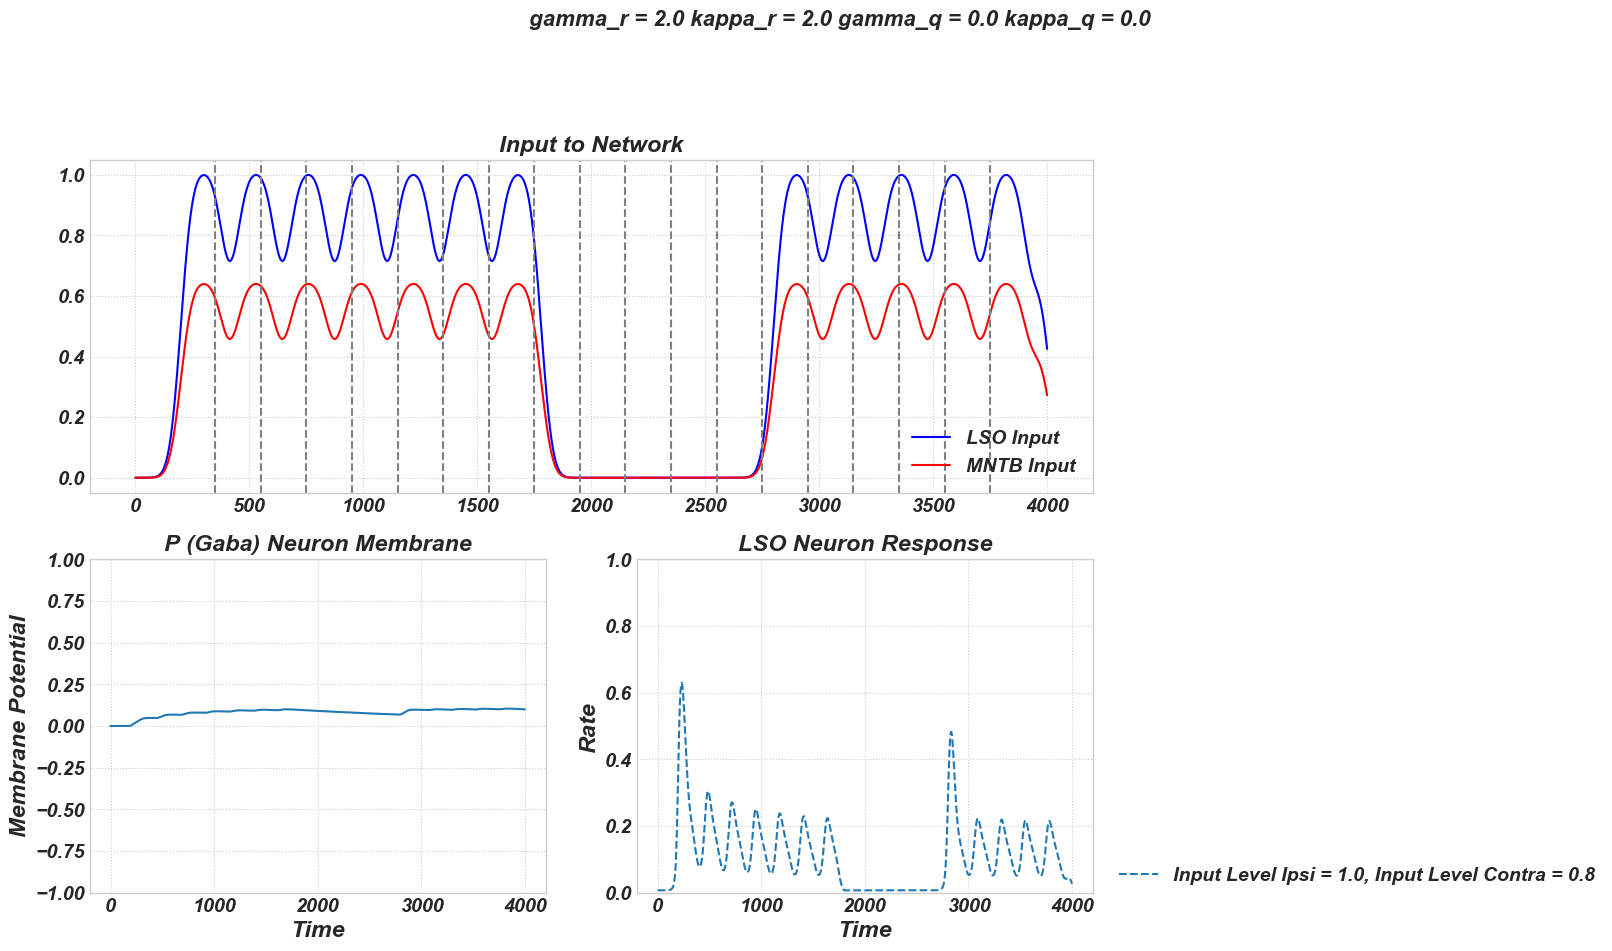

In [17]:
# Define the times when to probe
time_window = 200
probing_times = [300,700,1100,1500,1900,2300,2700,3100,3500]
probing_times = np.arange(350,len(t)-time_window,time_window)


fig = plt.figure(figsize=(20,15))

stri = 'gamma_r = '+str(gamma_r)+' kappa_r = '+str(kappa_r)+' gamma_q = '+str(gamma_q)+' kappa_q = '+str(kappa_q)
plt.suptitle(stri,fontsize=16)

ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
plt.plot(s_sbc_all[:,3],'blue',  label='LSO Input')
plt.plot(s_gbc_all[:,3],'red',  label='MNTB Input')
for i in probing_times:
    plt.axvline(x=i,linestyle='--',color='grey')
plt.title('Input to Network')
plt.legend()

# show LSO neuron membrane
diff_input =  s_sbc_all-s_gbc_all
diff_input = diff_input[:,3]
r = r_all[:,:,3]
q = q_all[:,:,3]
p = p_all[:,:,3]
# ax2 = plt.subplot2grid((3, 3), (1, 0), rowspan=1)
# for i in range(0,r.shape[0]):
#     plt.plot(r[i,:])
# plt.title('P (Gaba) Neuron Membrane')
# plt.xlabel('Time')
# plt.ylabel('Membrane Potential')
# plt.ylim([0.3,0.35])



ax2 = plt.subplot2grid((3, 3), (1, 0), rowspan=1)
for i in range(0,r.shape[0]):
    plt.plot(p[i,:])
plt.title('P (Gaba) Neuron Membrane')
plt.xlabel('Time')
plt.ylabel('Membrane Potential')
plt.ylim([-1.0,1.0])

# show MNTB neuron membrane
# ax2 = plt.subplot2grid((3, 3), (1, 1), rowspan=1)
# for i in range(0,r.shape[0]):
#     plt.plot(q[i,:])
# plt.title('MNTB Neuron Membrane')
# plt.xlabel('Time')
# plt.ylabel('Membrane Potential')
# plt.ylim([-1,1])


## show LSO neuron response
ax2 = plt.subplot2grid((3, 3), (1, 1), colspan=1)
for i in range(0,r.shape[0]):
    tmp = g_r_out(r[i,:])
    # normalize it
#     tmp = tmp -  np.min(tmp)
#     tmp = tmp / np.max(tmp)
    ax2.plot(tmp,linestyle='--',label='Input Level Ipsi = {0:.1f}, Input Level Contra = {1:.1f}'.format(sbc_input_intensities[i],gbc_input_intensities[i]))
# plt.axvline(x=0.0,linestyle='--',color='grey')
# plt.axhline(y=0.5,linestyle='--',color='grey')
plt.title('LSO Neuron Response')
plt.xlabel('Time')
plt.ylabel('Rate')
plt.ylim([0,1.0])
plt.legend(loc=(1.04,0))

# ## show LSO neuron response normalized
# ax2 = plt.subplot2grid((3, 3), (2, 0), colspan=2)
# for i in range(0,r.shape[0]):
#     j = i
#     tmp = g_r_out(r[i,j,probing_times])
#     # normalize it
#     tmp = tmp -  np.min(tmp)
#     tmp = tmp / np.max(tmp)
#     ax2.plot(diff_input[probing_times],tmp,linestyle='--',label='GABA_exc = {0:.1f}, GABA_inh = {1:.1f}'.format(gaba_exc[i],gaba_inh[j]))
# # plt.axvline(x=0.0,linestyle='--',color='grey')
# # plt.axhline(y=0.5,linestyle='--',color='grey')
# ax2.invert_xaxis()
# plt.title('LSO Neuron Response Normalized')
# plt.xlabel('ILD')
# plt.ylabel('Rate')
# # plt.ylim([0,1])
# plt.legend(loc=(1.04,0))

plt.show()



# Adaptation in ILD response curve

In [31]:

gbc_input_intensities = np.linspace(0,0.5,10)
sbc_input_intensities = np.linspace(1,0.5,10)


# store values for different parameters
q_all = np.zeros((len(gbc_input_intensities),len(t),freq_bands))
r_all = np.zeros((len(gbc_input_intensities),len(t),freq_bands))
p_all = np.zeros((len(gbc_input_intensities),len(t),freq_bands))

gaba_inh_values = np.zeros((len(t),freq_bands))
gaba_exc_values = np.zeros((len(t),freq_bands))

# define the spontaneous firing rate of neuron
spf_r = 0.0
r_all[:,0,:] = spf_r
############################################################
#                      Simulation                          #
############################################################
# for gamma_r in [0.0,1.0,5.0]:
#     for kappa_r in [0.0,1.0,5.0]:
for k in range(len(sbc_input_intensities)):
    
    ############################################################
    #                       Inputs                             #
    ############################################################
    s_gbc_all= np.zeros((len(t),freq_bands))
    s_sbc_all = np.zeros((len(t),freq_bands))

    # Define input signal in a plausible way (gaussian input signal over frequency bands?)
    # Define input signal in a plausible way (gaussian input signal over frequency bands?)
    sigma = 2.0

    # MNTB inhibitory input (contra-lateral)
    gbc_input_onset = 200
    gbc_input_duration = 500
    gbc_center_frequencyBand =3
    gbc_input_strength = gbc_input_intensities[k]
   
    # build ramps
    time_window = 200
    gap_window = 0
    for i in range(time_window,len(t)-time_window-1000,time_window+gap_window):
        s_gbc_all[i:i+time_window,gbc_center_frequencyBand] = 1 * gbc_input_strength

#     s_gbc_all[:,gbc_center_frequencyBand] = gbc_input_strength
    # create a linearly decreasing function in frequency band 'center_frequencyband'
    # and smear it with a gauss to effect the neighboring bands
    gbc_gauss_mask = gauss(np.linspace(0,freq_bands,freq_bands),freq_bands/2,sigma)
    s_gbc_all = convolve1d(s_gbc_all,weights=gbc_gauss_mask,axis=1,mode='constant')

    
    # LSO direct excitatory input (ipsi-lateral)
    sbc_input_onset = 200
    sbc_input_duration = 500
    sbc_center_frequencyBand = 3
    sbc_input_strength = sbc_input_intensities[k]
    
    # build ramps
#     time_window = 200
#     gap_window = 200
    for i in range(time_window,len(t)-time_window-1000,time_window+gap_window):
        s_sbc_all[i:i+time_window,sbc_center_frequencyBand] = 1 * sbc_input_strength

#     s_sbc_all[:,sbc_center_frequencyBand] = sbc_input_strength
     # create a linearly decreasing function in frequency band 'center_frequencyband'
    # and smear it with a gauss to effect the neighboring bands
    sbc_gauss_mask = gauss(np.linspace(0,freq_bands,freq_bands),freq_bands/2,sigma)
    s_sbc_all = convolve1d(s_sbc_all,weights=sbc_gauss_mask,axis=1,mode='constant')

    # Convolve with gauss curve to build a temporal ramp
    s_gbc_all = convolve1d(s_gbc_all,gauss(np.linspace(-50,50,s_gbc_all.shape[0]),0,1),0,mode='constant')
    s_sbc_all = convolve1d(s_sbc_all,gauss(np.linspace(-50,50,s_sbc_all.shape[0]),0,1),0,mode='constant')

    maxi = np.max([np.max(s_gbc_all),np.max(s_sbc_all)])
    s_gbc_all /= maxi
    s_sbc_all /= maxi

    s_sbc_all *= sbc_input_strength
    s_gbc_all *= gbc_input_strength

    for i in range(0, len(t)-1):
            for w in range(0,freq_bands):
                # E-E kernel
                ee_kernel = gauss(np.arange(freq_bands),w,0.5)
                ei_kernel = gauss(np.arange(freq_bands),w,0.1)
                ie_kernel = gauss(np.arange(freq_bands),w,0.1)
                ii_kernel = gauss(np.arange(freq_bands),w,1.0)

                # normalize it 
                ee_kernel /= np.max(ee_kernel)
                ei_kernel /= np.max(ie_kernel)
                ie_kernel /= np.max(ie_kernel)
                ii_kernel /= np.max(ie_kernel)
                
                # calculate GABA inhibition and store the values for later inspection (later do that in ode_r_bpc function)

                gaba_inh_values[i,w] =   p_all[k,i,w]*1
                gaba_exc_values[i,w] =   p_all[k,i,w]*2.5

                
                delay_factor = 20
                # as an MNTB input we use the value of the previously calculated time step. 
                # By that we have a fix delay between the onset of the signal of direct SBC cells and the MNTB 
                if i < delay_factor:
                    r_all[k,i+1,w] = r_all[k,i,w] +  dt * ode_r_bpc(r_all[k,i,w],s_sbc_all[i],ee_kernel,np.zeros(q_all.shape[2]),ei_kernel,spf_r,gaba_exc_values[i,w],gaba_inh_values[i,w])       
                else:
                    r_all[k,i+1,w] = r_all[k,i,w] +  dt * ode_r_bpc(r_all[k,i,w],s_sbc_all[i],ee_kernel,q_all[k,i-delay_factor,:],ei_kernel,spf_r,gaba_exc_values[i,w],gaba_inh_values[i,w])       

                q_all[k,i+1,w] = q_all[k,i,w] +  dt * ode_q_pc(q_all[k,i,w],s_gbc_all[i],ie_kernel,q_all[k,i,:],ii_kernel)
                p_all[k,i+1,w] = p_all[k,i,w] + dt * ode_p_pc(p_all[k,i,w], g_r_out(r_all[k,i,w]))

                


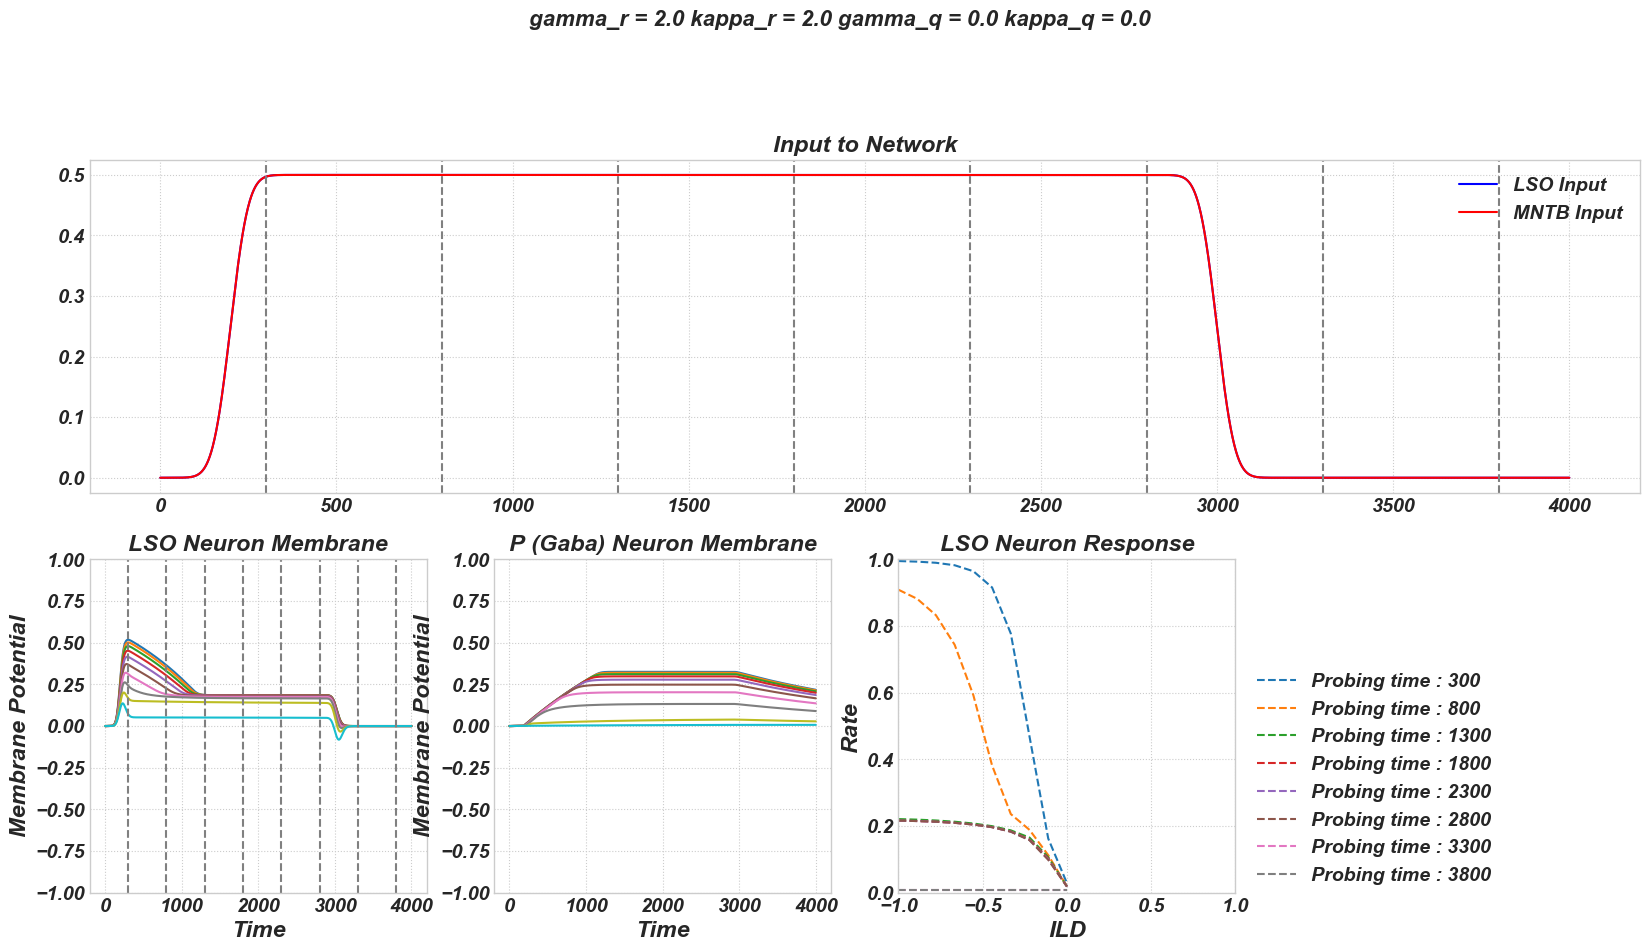

In [33]:
# Define the times when to probe
time_window = 200
probing_times = [250,520,740,980]
probing_times = [240,500,740,980,1220,1450,1680]
probing_times = [350,1700]
probing_times = np.arange(300,len(t)-time_window,500)
# probing_times = [500,3500]


fig = plt.figure(figsize=(20,15))

stri = 'gamma_r = '+str(gamma_r)+' kappa_r = '+str(kappa_r)+' gamma_q = '+str(gamma_q)+' kappa_q = '+str(kappa_q)
plt.suptitle(stri,fontsize=16)

ax1 = plt.subplot2grid((3, 4), (0, 0), colspan=4)
plt.plot(s_sbc_all[:,3],'blue',  label='LSO Input')
plt.plot(s_gbc_all[:,3],'red',  label='MNTB Input')
for i in probing_times:
    plt.axvline(x=i,linestyle='--',color='grey')
plt.title('Input to Network')
plt.legend()

# show LSO neuron membrane
diff_input =  s_sbc_all-s_gbc_all
diff_input = diff_input[:,3]
r = r_all[:,:,3]
q = q_all[:,:,3]
p = p_all[:,:,3]
ax2 = plt.subplot2grid((3, 4), (1, 0), rowspan=1)
for i in range(0,r.shape[0]):
    plt.plot(r[i,:])
for i in probing_times:
    plt.axvline(x=i,linestyle='--',color='grey')
plt.title('LSO Neuron Membrane')
plt.xlabel('Time')
plt.ylabel('Membrane Potential')
plt.ylim([-1,1])



ax2 = plt.subplot2grid((3, 4), (1, 1), rowspan=1)
for i in range(0,r.shape[0]):
    plt.plot(p[i,:])
plt.title('P (Gaba) Neuron Membrane')
plt.xlabel('Time')
plt.ylabel('Membrane Potential')
plt.ylim([-1.0,1.0])

# show MNTB neuron membrane
# ax2 = plt.subplot2grid((3, 3), (1, 1), rowspan=1)
# for i in range(0,r.shape[0]):
#     plt.plot(q[i,:])
# plt.title('MNTB Neuron Membrane')
# plt.xlabel('Time')
# plt.ylabel('Membrane Potential')
# plt.ylim([-1,1])


## show LSO neuron response
ax2 = plt.subplot2grid((3, 4), (1, 2), colspan=1)
for i in range(0,len(probing_times)):
    probing = probing_times[i]
    tmp = g_r_out(r[:,probing])
    diff = gbc_input_intensities-sbc_input_intensities
    ax2.plot(diff,tmp,linestyle='--',label='Probing time : ' + str(probing))
# plt.axvline(x=0.0,linestyle='--',color='grey')
# plt.axhline(y=0.5,linestyle='--',color='grey')

plt.title('LSO Neuron Response')
plt.xlabel('ILD')
plt.ylabel('Rate')
plt.ylim([0,1.0])
plt.xlim([-1,1])
plt.legend(loc=(1.04,0))

# ## show LSO neuron response normalized
# ax2 = plt.subplot2grid((3, 4), (2, 0), colspan=3)
# for i in range(0,r.shape[0]):
#     j = i
#     tmp = g_r_out(r[i,:])
#     # normalize it
#     ax2.plot(tmp,linestyle='--',label = 'Input Level Ipsi = {0:.1f}, Input Level Contra = {1:.1f}'.format(sbc_input_intensities[i],gbc_input_intensities[i]))
# # plt.axvline(x=0.0,linestyle='--',color='grey')
# # plt.axhline(y=0.5,linestyle='--',color='grey')
# for i in probing_times:
#     plt.axvline(x=i,linestyle='--',color='grey')
# plt.title('LSO Neuron Response Normalized')
# plt.xlabel('ILD')
# plt.ylabel('Rate')
# plt.legend(loc=(1.04,0))
# # plt.ylim([0,1])

plt.show()



In [12]:

sbc_input_intensities = np.linspace(1.0,0.0,20)
gbc_input_intensities = np.linspace(0.0,1.0,20)

adaptor_tone =np.linspace(1,0.0,10)


# store values for different parameters
q_all = np.zeros((len(adaptor_tone), len(gbc_input_intensities),len(t),freq_bands))
r_all = np.zeros((len(adaptor_tone), len(gbc_input_intensities),len(t),freq_bands))
p_all = np.zeros((len(adaptor_tone), len(gbc_input_intensities),len(t),freq_bands))

gaba_inh_values = np.zeros((len(t),freq_bands))
gaba_exc_values = np.zeros((len(t),freq_bands))

# define the spontaneous firing rate of neuron
spf_r = 0.0
r_all[:,0,:] = spf_r
############################################################
#                      Simulation                          #
############################################################
# for gamma_r in [0.0,1.0,5.0]:
#     for kappa_r in [0.0,1.0,5.0]:
for l in range(len(adaptor_tone)):
    for k in range(len(sbc_input_intensities)):

        ############################################################
        #                       Inputs                             #
        ############################################################
        s_gbc_all= np.zeros((len(t),freq_bands))
        s_sbc_all = np.zeros((len(t),freq_bands))

        # Define input signal in a plausible way (gaussian input signal over frequency bands?)
        # Define input signal in a plausible way (gaussian input signal over frequency bands?)
        sigma = 2.0

        # MNTB inhibitory input (contra-lateral)
        gbc_input_onset = 200
        gbc_input_duration = 500
        gbc_center_frequencyBand =3
        gbc_input_strength = gbc_input_intensities[k]

        # build ramps
        time_window = 200
        gap_window = 0
        for i in range(time_window,len(t)-time_window-3000,time_window+gap_window):
            s_gbc_all[i:i+time_window,gbc_center_frequencyBand] = 0 

        for i in range(len(t)-time_window-2500,len(t),time_window+gap_window):
            s_gbc_all[i:i+time_window,gbc_center_frequencyBand] = 1 * gbc_input_strength

    #     s_gbc_all[:,gbc_center_frequencyBand] = gbc_input_strength
        # create a linearly decreasing function in frequency band 'center_frequencyband'
        # and smear it with a gauss to effect the neighboring bands
        gbc_gauss_mask = gauss(np.linspace(0,freq_bands,freq_bands),freq_bands/2,sigma)
        s_gbc_all = convolve1d(s_gbc_all,weights=gbc_gauss_mask,axis=1,mode='constant')


        # LSO direct excitatory input (ipsi-lateral)
        sbc_input_onset = 200
        sbc_input_duration = 500
        sbc_center_frequencyBand = 3
        sbc_input_strength = sbc_input_intensities[k]

        # build ramps
    #     time_window = 200
    #     gap_window = 200
        for i in range(time_window,len(t)-time_window-3000,time_window+gap_window):
            s_sbc_all[i:i+time_window,sbc_center_frequencyBand] = adaptor_tone[l]

        for i in range(len(t)-time_window-2500,len(t),time_window+gap_window):
            s_sbc_all[i:i+time_window,sbc_center_frequencyBand] = 1 * sbc_input_strength

    #     s_sbc_all[:,sbc_center_frequencyBand] = sbc_input_strength
         # create a linearly decreasing function in frequency band 'center_frequencyband'
        # and smear it with a gauss to effect the neighboring bands
        sbc_gauss_mask = gauss(np.linspace(0,freq_bands,freq_bands),freq_bands/2,sigma)
        s_sbc_all = convolve1d(s_sbc_all,weights=sbc_gauss_mask,axis=1,mode='constant')

        # Convolve with gauss curve to build a temporal ramp
        s_gbc_all = convolve1d(s_gbc_all,gauss(np.linspace(-50,50,s_gbc_all.shape[0]),0,1),0,mode='constant')
        s_sbc_all = convolve1d(s_sbc_all,gauss(np.linspace(-50,50,s_sbc_all.shape[0]),0,1),0,mode='constant')

        maxi = np.max([np.max(s_gbc_all),np.max(s_sbc_all)])
    #     s_gbc_all /= maxi
    #     s_sbc_all /= maxi

        s_gbc_all /= 100
        s_sbc_all /= 100

        for i in range(0, len(t)-1):
                for w in range(0,freq_bands):
                    # E-E kernel
                    ee_kernel = gauss(np.arange(freq_bands),w,0.5)
                    ei_kernel = gauss(np.arange(freq_bands),w,0.1)
                    ie_kernel = gauss(np.arange(freq_bands),w,0.1)
                    ii_kernel = gauss(np.arange(freq_bands),w,1.0)

                    # normalize it 
                    ee_kernel /= np.max(ee_kernel)
                    ei_kernel /= np.max(ie_kernel)
                    ie_kernel /= np.max(ie_kernel)
                    ii_kernel /= np.max(ie_kernel)

                    # calculate GABA inhibition and store the values for later inspection (later do that in ode_r_bpc function)

                    gaba_inh_values[i,w] =   p_all[l,k,i,w]*1
                    gaba_exc_values[i,w] =   p_all[l,k,i,w]*2.5




                    delay_factor = 20
                    # as an MNTB input we use the value of the previously calculated time step. 
                    # By that we have a fix delay between the onset of the signal of direct SBC cells and the MNTB 
                    if i < delay_factor:
                        r_all[l,k,i+1,w] = r_all[l,k,i,w] +  dt * ode_r_bpc(r_all[l,k,i,w],s_sbc_all[i],ee_kernel,np.zeros(q_all.shape[3]),ei_kernel,spf_r,gaba_exc_values[i,w],gaba_inh_values[i,w])       
                    else:
                        r_all[l,k,i+1,w] = r_all[l,k,i,w] +  dt * ode_r_bpc(r_all[l,k,i,w],s_sbc_all[i],ee_kernel,q_all[l,k,i-delay_factor,:],ei_kernel,spf_r,gaba_exc_values[i,w],gaba_inh_values[i,w])       

                    q_all[l,k,i+1,w] = q_all[l,k,i,w] +  dt * ode_q_pc(q_all[l,k,i,w],s_gbc_all[i],ie_kernel,q_all[l,k,i,:],ii_kernel)

                    p_all[l,k,i+1,w] = p_all[l,k,i,w] + dt * ode_p_pc(p_all[l,k,i,w],g_r_out(r_all[l,k,i,w]))



    #     fig = plt.figure()        
    #     plt.plot(gaba_inh_values[:,3])
    #     plt.plot(gaba_exc_values[:,3])
    #     plt.ylim([0,1.0])

# plt.show()

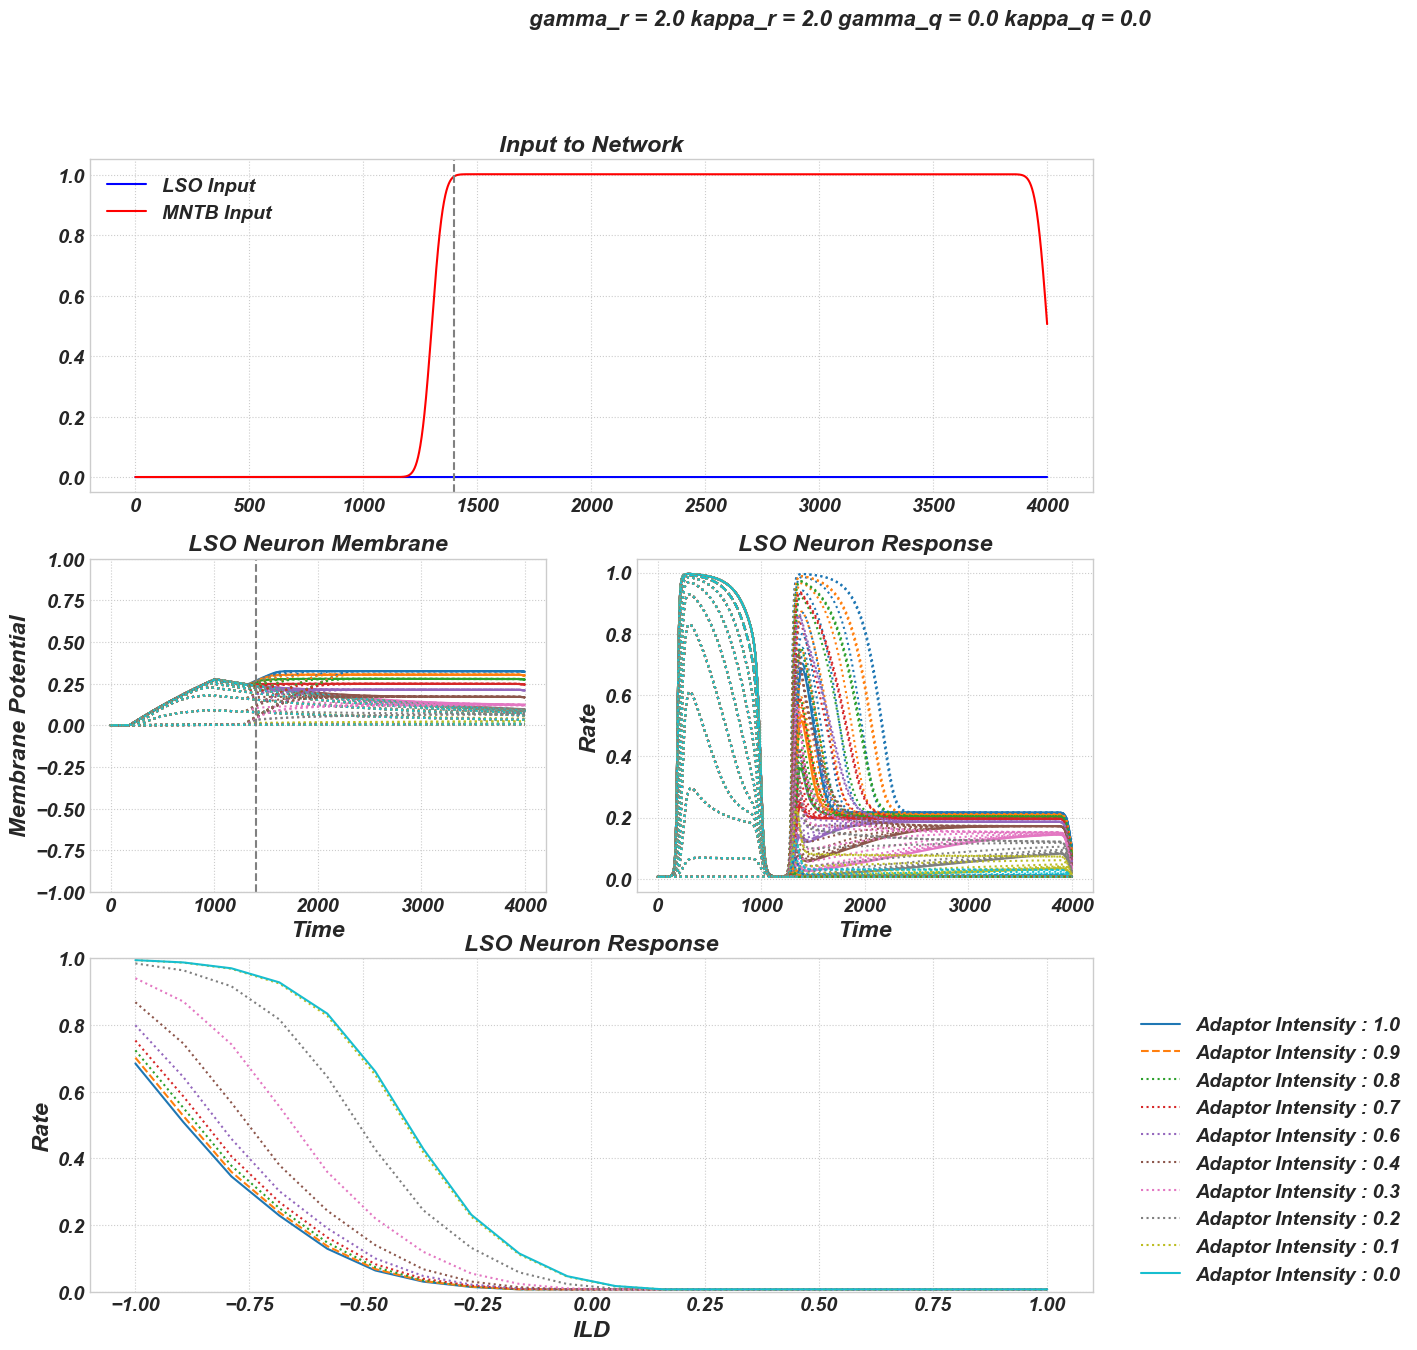

In [13]:
# Define the times when to probe
time_window = 200
probing_times = np.arange(350,len(t)-time_window,time_window)
probing_times = [1400]


fig = plt.figure(figsize=(20,15))

stri = 'gamma_r = '+str(gamma_r)+' kappa_r = '+str(kappa_r)+' gamma_q = '+str(gamma_q)+' kappa_q = '+str(kappa_q)
plt.suptitle(stri,fontsize=16)

ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
plt.plot(s_sbc_all[:,3],'blue',  label='LSO Input')
plt.plot(s_gbc_all[:,3],'red',  label='MNTB Input')
for i in probing_times:
    plt.axvline(x=i,linestyle='--',color='grey')
plt.title('Input to Network')
plt.legend()

# show LSO neuron membrane
diff_input =  s_sbc_all-s_gbc_all
diff_input = diff_input[:,3]
r = r_all[:,:,:,3]
q = q_all[:,:,:,3]
p = p_all[:,:,:,3]
ax2 = plt.subplot2grid((3, 3), (1, 0), rowspan=1)
for j in range(0,len(adaptor_tone)):
    if j == 0:
        line_style = '-'
    elif j == 1:
        line_style = '--'
    else:
        line_style = ':'

    for i in range(0,r.shape[1]):
        plt.plot(p[j,i,:],linestyle=line_style)
for i in probing_times:
    plt.axvline(x=i,linestyle='--',color='grey')
plt.title('LSO Neuron Membrane')
plt.xlabel('Time')
plt.ylabel('Membrane Potential')
plt.ylim([-1.0,1])


# show MNTB neuron membrane
# ax2 = plt.subplot2grid((3, 3), (1, 1), rowspan=1)
# for i in range(0,r.shape[0]):
#     plt.plot(q[i,:])
# plt.title('MNTB Neuron Membrane')
# plt.xlabel('Time')
# plt.ylabel('Membrane Potential')
# plt.ylim([-1,1])

## show LSO neuron response
ax2 = plt.subplot2grid((3, 3), (1, 1), colspan=1)
for j in range(0,len(adaptor_tone)):
    if j == 0:
        line_style = '-'
    elif j == 1:
        line_style = '--'
    else:
        line_style = ':'

    for i in range(0,r.shape[1]):
        tmp = g_r_out(r[j,i,:])
        # normalize it
    #     tmp = tmp -  np.min(tmp)
    #     tmp = tmp / np.max(tmp)
        ax2.plot(tmp,linestyle=line_style,label='Level Difference = {0:.1f}'.format(sbc_input_intensities[i]-gbc_input_intensities[i]))
# plt.axvline(x=0.0,linestyle='--',color='grey')
# plt.axhline(y=0.5,linestyle='--',color='grey')
plt.title('LSO Neuron Response')
plt.xlabel('Time')
plt.ylabel('Rate')
# plt.ylim([0,1])
# plt.legend(loc=(1.04,0))


# ## show LSO neuron response normalized
ax2 = plt.subplot2grid((3, 3), (2, 0), colspan=2)
for j in range(0,len(adaptor_tone)):
    if j == 0 or j == len(adaptor_tone)-1:
        line_style = '-'
    elif j == 1:
        line_style = '--'
    else:
        line_style = ':'
    for i in range(0,len(probing_times)):
        probing = probing_times[i]
        tmp = g_r_out(r[j,:,probing])
        diff = gbc_input_intensities-sbc_input_intensities
        ax2.plot(diff,tmp,linestyle=line_style,label='Adaptor Intensity : {0:.1f}'.format(adaptor_tone[j]))
# plt.axvline(x=0.0,linestyle='--',color='grey')
# plt.axhline(y=0.5,linestyle='--',color='grey')
plt.title('LSO Neuron Response')
plt.xlabel('ILD')
plt.ylabel('Rate')
plt.ylim([0,1.0])
plt.legend(loc=(1.04,0))

plt.show()



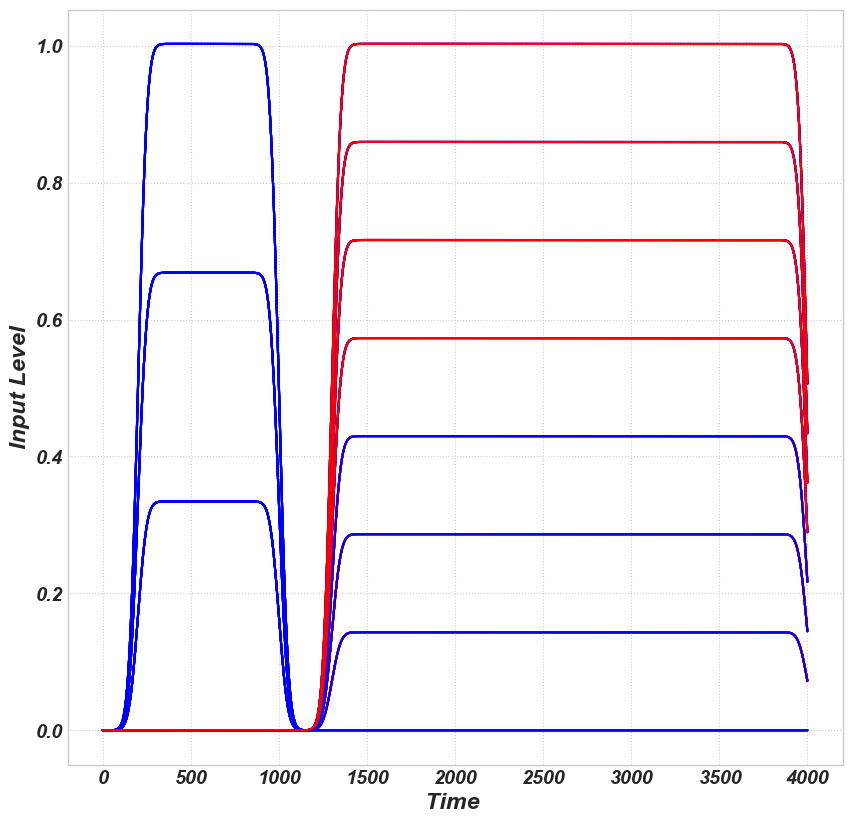

In [14]:

sbc_input_intensities = np.linspace(1.0,0.0,8)
gbc_input_intensities = np.linspace(0.0,1.0,8)

adaptor_tone =np.linspace(1,0.0,4)


# store values for different parameters
q_all = np.zeros((len(adaptor_tone), len(gbc_input_intensities),len(t),freq_bands))
r_all = np.zeros((len(adaptor_tone), len(gbc_input_intensities),len(t),freq_bands))
p_all = np.zeros((len(adaptor_tone), len(gbc_input_intensities),len(t),freq_bands))

gaba_inh_values = np.zeros((len(t),freq_bands))
gaba_exc_values = np.zeros((len(t),freq_bands))

# define the spontaneous firing rate of neuron
spf_r = 0.0
r_all[:,0,:] = spf_r
############################################################
#                      Simulation                          #
############################################################
# for gamma_r in [0.0,1.0,5.0]:
#     for kappa_r in [0.0,1.0,5.0]:
fig = plt.figure(figsize=(10,10))
for l in range(len(adaptor_tone)):
    for k in range(len(sbc_input_intensities)):

        ############################################################
        #                       Inputs                             #
        ############################################################
        s_gbc_all= np.zeros((len(t),freq_bands))
        s_sbc_all = np.zeros((len(t),freq_bands))

        # Define input signal in a plausible way (gaussian input signal over frequency bands?)
        # Define input signal in a plausible way (gaussian input signal over frequency bands?)
        sigma = 2.0

        # MNTB inhibitory input (contra-lateral)
        gbc_input_onset = 200
        gbc_input_duration = 500
        gbc_center_frequencyBand =3
        gbc_input_strength = gbc_input_intensities[k]

        # build ramps
        time_window = 200
        gap_window = 0
        for i in range(time_window,len(t)-time_window-3000,time_window+gap_window):
            s_gbc_all[i:i+time_window,gbc_center_frequencyBand] = 0 

        for i in range(len(t)-time_window-2500,len(t),time_window+gap_window):
            s_gbc_all[i:i+time_window,gbc_center_frequencyBand] = 1 * gbc_input_strength

    #     s_gbc_all[:,gbc_center_frequencyBand] = gbc_input_strength
        # create a linearly decreasing function in frequency band 'center_frequencyband'
        # and smear it with a gauss to effect the neighboring bands
        gbc_gauss_mask = gauss(np.linspace(0,freq_bands,freq_bands),freq_bands/2,sigma)
        s_gbc_all = convolve1d(s_gbc_all,weights=gbc_gauss_mask,axis=1,mode='constant')


        # LSO direct excitatory input (ipsi-lateral)
        sbc_input_onset = 200
        sbc_input_duration = 500
        sbc_center_frequencyBand = 3
        sbc_input_strength = sbc_input_intensities[k]

        # build ramps
    #     time_window = 200
    #     gap_window = 200
        for i in range(time_window,len(t)-time_window-3000,time_window+gap_window):
            s_sbc_all[i:i+time_window,sbc_center_frequencyBand] = adaptor_tone[l]

        for i in range(len(t)-time_window-2500,len(t),time_window+gap_window):
            s_sbc_all[i:i+time_window,sbc_center_frequencyBand] = 1 * sbc_input_strength

    #     s_sbc_all[:,sbc_center_frequencyBand] = sbc_input_strength
         # create a linearly decreasing function in frequency band 'center_frequencyband'
        # and smear it with a gauss to effect the neighboring bands
        sbc_gauss_mask = gauss(np.linspace(0,freq_bands,freq_bands),freq_bands/2,sigma)
        s_sbc_all = convolve1d(s_sbc_all,weights=sbc_gauss_mask,axis=1,mode='constant')

        # Convolve with gauss curve to build a temporal ramp
        s_gbc_all = convolve1d(s_gbc_all,gauss(np.linspace(-50,50,s_gbc_all.shape[0]),0,1),0,mode='constant')
        s_sbc_all = convolve1d(s_sbc_all,gauss(np.linspace(-50,50,s_sbc_all.shape[0]),0,1),0,mode='constant')

        maxi = np.max([np.max(s_gbc_all),np.max(s_sbc_all)])
    #     s_gbc_all /= maxi
    #     s_sbc_all /= maxi

        s_gbc_all /= 100
        s_sbc_all /= 100

#         for i in range(0, len(t)-1):
#                 for w in range(0,freq_bands):
                    # E-E kernel
#                     ee_kernel = gauss(np.arange(freq_bands),w,0.5)
#                     ei_kernel = gauss(np.arange(freq_bands),w,0.1)
#                     ie_kernel = gauss(np.arange(freq_bands),w,0.1)
#                     ii_kernel = gauss(np.arange(freq_bands),w,1.0)

#                     # normalize it 
#                     ee_kernel /= np.max(ee_kernel)
#                     ei_kernel /= np.max(ie_kernel)
#                     ie_kernel /= np.max(ie_kernel)
#                     ii_kernel /= np.max(ie_kernel)

#                     # calculate GABA inhibition and store the values for later inspection (later do that in ode_r_bpc function)

#                     gaba_inh_values[i,w] =   p_all[l,k,i,w]*1
#                     gaba_exc_values[i,w] =   p_all[l,k,i,w]*5




#                     delay_factor = 20
#                     # as an MNTB input we use the value of the previously calculated time step. 
#                     # By that we have a fix delay between the onset of the signal of direct SBC cells and the MNTB 
#                     if i < delay_factor:
#                         r_all[l,k,i+1,w] = r_all[l,k,i,w] +  dt * ode_r_bpc(r_all[l,k,i,w],s_sbc_all[i],ee_kernel,np.zeros(q_all.shape[3]),ei_kernel,spf_r,gaba_exc_values[i,w],gaba_inh_values[i,w])       
#                     else:
#                         r_all[l,k,i+1,w] = r_all[l,k,i,w] +  dt * ode_r_bpc(r_all[l,k,i,w],s_sbc_all[i],ee_kernel,q_all[l,k,i-delay_factor,:],ei_kernel,spf_r,gaba_exc_values[i,w],gaba_inh_values[i,w])       

#                     q_all[l,k,i+1,w] = q_all[l,k,i,w] +  dt * ode_q_pc(q_all[l,k,i,w],s_gbc_all[i],ie_kernel,q_all[l,k,i,:],ii_kernel)

#                     p_all[l,k,i+1,w] = p_all[l,k,i,w] + dt * ode_p_pc(p_all[l,k,i,w],g_r_out(r_all[l,k,i,w]))






        plt.plot(s_sbc_all[:,3],'blue',  label='LSO Input')
        plt.plot(s_gbc_all[:,3],'red',  label='MNTB Input')        

plt.ylabel('Input Level')       
plt.xlabel('Time ')
plt.show()